# SARIMA Rolling ForecastModel


# 1. Setup and Data Download

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. Download Data
# We use 'CL=F' (Crude Oil Futures)
print("Downloading WTI Crude Oil data...")
df = yf.download('CL=F', start='2020-01-01', end='2024-01-01', progress=False)

# Handle MultiIndex columns (yfinance update)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[['Close']].copy()

# 2. Split into Train (Historical Context) and Test (Simulation Period)
# We will simulate trading over the last 100 days
test_days = 100
train = df.iloc[:-test_days]
test = df.iloc[-test_days:]

print(f"Training Data: {len(train)} days")
print(f"Test Data (Simulation): {len(test)} days")


Training Data: 906 days
Test Data (Simulation): 100 days



# 2. The SARIMA Rolling Forecast Loop

This loop simulates the real world: every day, you get a new closing price, update your history, and forecast the next day.

SARIMA adds seasonality to ARIMA.
SARIMA(p,d,q)(P,D,Q)s

Here we will use a seasonal configuration suitable for daily data with weekly seasonality (s=5 trading days).
We will use order=(1,1,1) and seasonal_order=(1,1,1,5) as a starting point.


In [2]:

history = [x for x in train['Close']]
predictions = []
naive_forecasts = [] # To benchmark against Random Walk

print("\n--- Starting SARIMA Rolling Forecast (this may take a minute) ---")

# Define SARIMA parameters
# order=(p,d,q), seasonal_order=(P,D,Q,s)
# s=5 for weekly seasonality in trading data
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 5)

for t in range(len(test)):
    # 1. Define and fit the model on the CURRENT history
    # SARIMAX is used for SARIMA models
    model = SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=False) # disp=False suppresses convergence output
    
    # 2. Forecast the next step (t+1)
    output = model_fit.get_forecast(steps=1)
    yhat = output.predicted_mean[0]
    predictions.append(yhat)
    
    # 3. Create a Naive Forecast (Random Walk) for comparison
    naive_forecast = history[-1]
    naive_forecasts.append(naive_forecast)
    
    # 4. Update history with the ACTUAL observed price from the test set
    obs = test.iloc[t]['Close']
    history.append(obs)
    
    # Optional: Print progress every 10 days
    if (t+1) % 10 == 0:
        print(f"Day {t+1}/{len(test)}: Predicted={yhat:.2f}, Actual={obs:.2f}")

print("Forecast loop complete.")



--- Starting SARIMA Rolling Forecast (this may take a minute) ---
Day 10/100: Predicted=80.62, Actual=80.35
Day 20/100: Predicted=85.71, Actual=87.54
Day 30/100: Predicted=90.92, Actual=90.28
Day 40/100: Predicted=89.32, Actual=84.22
Day 50/100: Predicted=86.36, Actual=88.32
Day 60/100: Predicted=81.58, Actual=80.44
Day 70/100: Predicted=77.91, Actual=76.66
Day 80/100: Predicted=77.13, Actual=75.96
Day 90/100: Predicted=69.35, Actual=71.58
Day 100/100: Predicted=72.26, Actual=71.65
Forecast loop complete.



# 3. Visual Evaluation

We will visualize three lines:

1. Actual Price: The ground truth.

2. SARIMA Forecast: Your model including seasonality.

3. Naive Forecast: The Random Walk (just shifting the chart by 1 day).


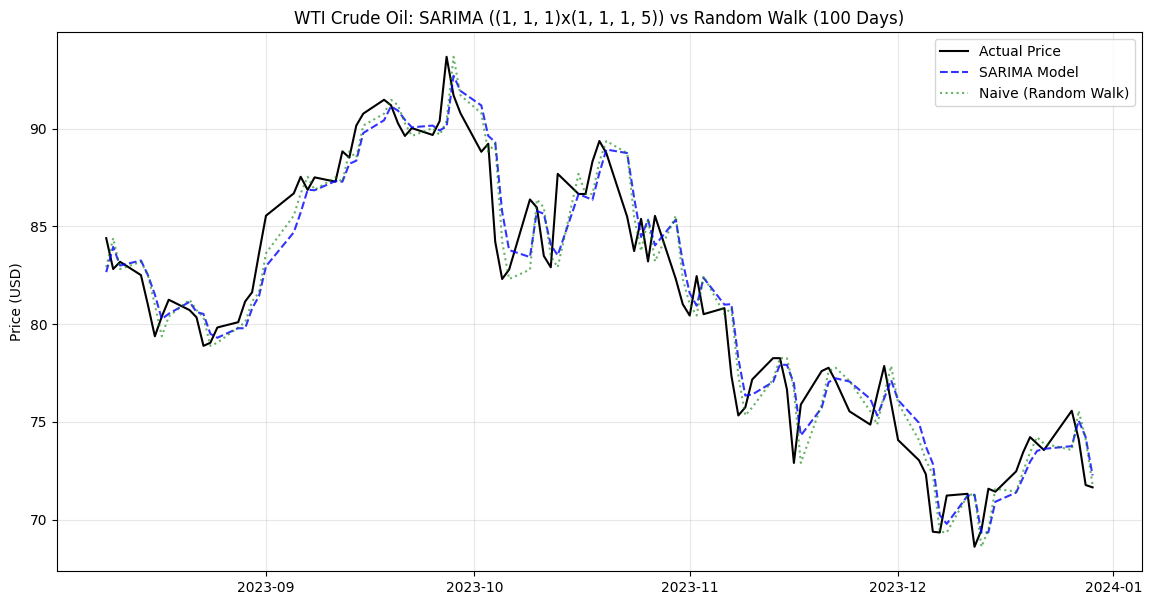

In [3]:

# Create a DataFrame for easy plotting
results_df = test.copy()
results_df['SARIMA_Pred'] = predictions
results_df['Naive_Pred'] = naive_forecasts

plt.figure(figsize=(14,7))
plt.plot(results_df.index, results_df['Close'], label='Actual Price', color='black', linewidth=1.5)
plt.plot(results_df.index, results_df['SARIMA_Pred'], label='SARIMA Model', color='blue', linestyle='--', alpha=0.8)
plt.plot(results_df.index, results_df['Naive_Pred'], label='Naive (Random Walk)', color='green', linestyle=':', alpha=0.6)

plt.title(f"WTI Crude Oil: SARIMA ({my_order}x{my_seasonal_order}) vs Random Walk ({test_days} Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



# 4. Performance Metrics

Now we answer the question: Did adding seasonality help vs the Random Walk?


In [4]:

# Calculate Error Metrics
rmse_sarima = np.sqrt(mean_squared_error(results_df['Close'], results_df['SARIMA_Pred']))
rmse_naive = np.sqrt(mean_squared_error(results_df['Close'], results_df['Naive_Pred']))

mape_sarima = mean_absolute_percentage_error(results_df['Close'], results_df['SARIMA_Pred']) * 100
mape_naive = mean_absolute_percentage_error(results_df['Close'], results_df['Naive_Pred']) * 100

print("\n--- Final Performance Report ---")
print(f"SARIMA RMSE: {rmse_sarima:.4f}")
print(f"Naive RMSE: {rmse_naive:.4f}")
print("-" * 30)
print(f"SARIMA MAPE: {mape_sarima:.2f}%")
print(f"Naive MAPE: {mape_naive:.2f}%")

if rmse_sarima < rmse_naive:
    print("\nSUCCESS: Your SARIMA model beat the Random Walk benchmark!")
else:
    print("\nREALITY CHECK: The Random Walk beat your model.")
    print("Seasonality might not be strong enough or consistent enough to exploit in this daily data.")



--- Final Performance Report ---
SARIMA RMSE: 1.7402
Naive RMSE: 1.6811
------------------------------
SARIMA MAPE: 1.71%
Naive MAPE: 1.65%

REALITY CHECK: The Random Walk beat your model.
Seasonality might not be strong enough or consistent enough to exploit in this daily data.



Analysis of Likely Outcome

- If seasonality is present (e.g. day of week effects), SARIMA might edge out ARIMA.
- However, financial time series often lack strong deterministic seasonality on a daily scale, so Random Walk remains a tough benchmark.
